In [1]:
%matplotlib inline
import numpy as np
from sympy import fwht
import os
from itertools import combinations
import random
from deap import base, creator, tools, algorithms
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [2]:
def byte2bit(_in: np.array):
    assert _in.dtype == np.uint8
    return np.unpackbits(_in)

def bit2byte(_in: np.array):
    assert _in.dtype == np.uint8
    return np.packbits(_in)

def random_input():
    return byte2bit(np.random.randint(0,256,dtype=np.uint8))

def random_sbox():
    return np.random.permutation(256)

def get_bool_func(sbox: np.array, j=0):
    assert 0 <= j <= 7
    bit = 1 << j # take jth bit
    bool_func_arr = np.bitwise_and(sbox,bit) # take the significant bit of each sbox
    bool_func_arr = np.right_shift(bool_func_arr,j) # right shift to get boolean array
    return bool_func_arr

In [3]:
np.right_shift(2,1)

np.int64(1)

In [4]:
bit2byte(byte2bit(np.array([23,12],dtype=np.uint8)))

array([23, 12], dtype=uint8)

In [5]:
a = random_sbox()

In [6]:
get_bool_func(a,1)

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1], dtype=int32)

In [7]:
get_bool_func(np.arange(256,dtype=np.uint8),0)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=uint8)

In [8]:
def nonlinearity_bool(bool_func, j=0):
    wave_vector = (-2*np.copy(bool_func))+1 # equivalent to np.power(-1, bool_func) for 0 and 1 (0->+1, 1->-1)
    transformed = fwht(wave_vector) #can't get it faster
    M = np.max(np.abs(transformed).astype(np.float64))
    return 128 - (M/2)

# optimization goal
def nonlinearity(sbox):
    nonlins = []
    for j in range(8):
        bool_func = get_bool_func(sbox,j).astype(np.float64)
        nonlins.append(nonlinearity_bool(bool_func,j))
    return np.min(nonlins)

In [9]:
def swap(individual, i_j):
    i,j = i_j
    temp = individual[i]
    individual[i] = individual[j]
    individual[j] = temp
    return individual

def mutate(individual):
    n = len(individual)
    i = np.random.randint(n)
    j = (np.random.randint(n) + i - 1)%n
    swap(individual,(i,j))
    return individual,

def evaluate(individual):
    nonlin = nonlinearity(individual)
    return nonlin, #maybe extend to multiobj

In [21]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, random_sbox)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=0.4)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)


population = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)
ea_final_pop, ea_log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)

d:\studia_2\2nd semester\Crypto\.wenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\studia_2\2nd semester\Crypto\.wenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg  	min	max	std    
0  	50    	99.32	92 	102	2.48548
1  	29    	100.24	94 	104	2.06456
2  	25    	100.96	96 	104	2.27121
3  	31    	100.48	92 	104	2.7874 
4  	26    	101.2 	96 	104	2.43311
5  	27    	102.56	94 	104	2.04118
6  	37    	102.76	94 	104	2.46219
7  	31    	103.6 	98 	104	1.26491
8  	36    	103.76	100	104	0.763151
9  	34    	103.84	102	104	0.542586
10 	26    	103.84	102	104	0.542586
11 	32    	103.72	102	104	0.693974
12 	23    	103.8 	102	104	0.6     
13 	38    	103.64	102	104	0.768375
14 	36    	103.72	102	104	0.693974
15 	34    	103.8 	102	106	0.72111 
16 	26    	103.8 	102	106	0.72111 
17 	32    	103.96	102	106	0.747262
18 	32    	104.04	102	106	0.747262
19 	30    	104.12	102	106	0.930376
20 	28    	104.12	102	106	1.22703 
21 	32    	104.8 	102	106	1.2     
22 	35    	104.92	102	106	1.21392 
23 	20    	105.4 	102	106	1.07703 
24 	30    	105.48	104	106	0.877268
25 	30    	105.44	102	106	0.983056
26 	26    	105.44	104	106	0.897998
27 	25    	105.48	104	106	0.877

In [29]:
def plot_log(log):
    min_ = log.select("min")
    max_ = log.select("max")
    avg_ = log.select("avg")
    std_ = log.select("std")
    evals = np.cumsum(log.select("nevals"))
    plt.plot(evals, avg_, label="avg")
    plt.plot(evals, max_, label="max")
    plt.plot(evals, min_, label="min")
    plt.fill_between(evals, np.clip(np.array(avg_)-np.array(std_),min=min_), np.clip(np.array(avg_)+np.array(std_),max=max_), alpha=0.2)
    plt.legend()
    plt.xlabel("Evaluations")
    return plt.ylabel("Fitness")

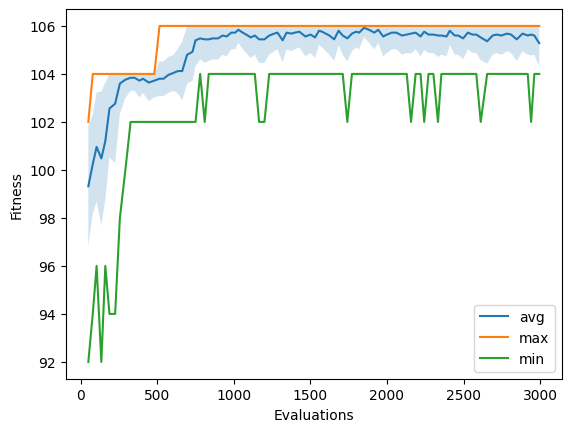

In [30]:
plot_log(ea_log)
plt.show()

In [ ]:
def localSearch(individual, toolbox, iter_limit=None, stats=None, halloffame=None, verbose=True):
    population = [individual]
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    gen = 1
    while True:
        improvement = False 
        nevals = 0
        for move in toolbox.neighbors(individual):
            new_individual = toolbox.clone(individual)
            new_individual = toolbox.apply_move(new_individual, move)
            fitness = toolbox.evaluate(new_individual)
            nevals += 1
            new_individual.fitness.values = fitness
            if fitness[0] > individual.fitness.values[0]:
                improvement = True
                break
            if iter_limit is not None and nevals >= iter_limit: # 256 choose 2 is around 32k, which would cause the algorithm to run for like half an hour
                break
        
        if improvement:
            individual = new_individual

        if halloffame is not None:
            halloffame.update([individual])
        
        record = stats.compile([individual]) if stats else {}
        logbook.record(gen=gen, nevals=nevals, **record)
        if verbose:
            print(logbook.stream)
        gen += 1
        
        if not improvement:
            break

    return individual, logbook

In [31]:
def neighbours(*_):
    pairs = list(combinations(range(256),2))
    random.shuffle(pairs)
    return pairs

toolbox.register("neighbors", neighbours)
toolbox.register("apply_move", swap)

ITER_LIMIT = 3000
final_ind, ls_log = localSearch(toolbox.individual(), toolbox, iter_limit=ITER_LIMIT, stats=stats, verbose=True)

gen	nevals	avg	min	max	std
0  	1     	96 	96 	96 	0  
1  	1     	98 	98 	98 	0  
2  	3     	100	100	100	0  
3  	6     	102	102	102	0  
4  	34    	104	104	104	0  
5  	3000  	104	104	104	0  


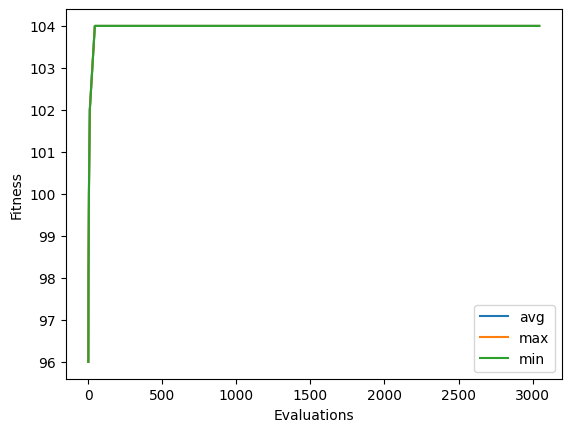

In [32]:
plot_log(ls_log)
plt.show()

In [19]:
def random_search(samples, toolbox, stats=None, halloffame=None, verbose=True):
    population = toolbox.population(samples)
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    return population, logbook


In [23]:
evaluated_sample, rs_log = random_search(3000,toolbox,stats)

gen	nevals	avg   	min	max	std    
0  	3000  	98.934	84 	106	2.65097
